# IEEE Fraud Detection Competition
![fraud](https://abcountrywide.com.au/wp-content/uploads/2018/04/fraud.jpg)

In this kernel I do some basic exploritory data analysis on the IEEE Fraud Detection dataset. Please upvote if you find this kernel helpful. I will continue to update as I find more discoveries. I suggest you also read the complete competition overview and data description found in the competition page.

I purposefully show all of my code. The intention is to not only show the results, but also have clear code that shows how similar analysis can be done on any dataset.

From the [competition overview](https://www.kaggle.com/c/ieee-fraud-detection/overview):

*In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.*
   
*If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.*

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [3]:
# List all the files in the input directory
!ls -GFlash --color ../input/ieee-fraud-detection

total 1.3G
4.0K drwxrwxr-x  2 zhou 4.0K Jul 17 10:39 ./
4.0K drwxrwxr-x 24 zhou 4.0K Jul 17 10:38 ../
5.9M -rw-r--r--  1 zhou 5.8M Jul 15 00:19 sample_submission.csv
 25M -rw-r--r--  1 zhou  25M Jul 15 00:19 test_identity.csv
585M -rw-r--r--  1 zhou 585M Jul 15 00:19 test_transaction.csv
 26M -rw-r--r--  1 zhou  26M Jul 15 00:19 train_identity.csv
652M -rw-r--r--  1 zhou 652M Jul 15 00:19 train_transaction.csv


# Data

In the competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

In [3]:
# Transaction CSVs
train_transaction = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
test_transaction = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
test_identity = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
# Sample Submissions
ss = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [21]:
train_transaction.loc[[0]]

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   

   card2  card3     card4  card5  ... V330  V331  V332  V333  V334 V335 V336  \
0    NaN  150.0  discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN  NaN   

   V337  V338  V339  
0   NaN   NaN   NaN  

[1 rows x 394 columns]

In [22]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [23]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


- 24.4% of TransactionIDs in **train** (144233 / 590540) have an associated train_identity.
- 28.0% of TransactionIDs in **test** (144233 / 590540) have an associated train_identity.

# Train vs Test are Time Series Split

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

We will look into this more when reviewing differences in distribution of features between train and test.

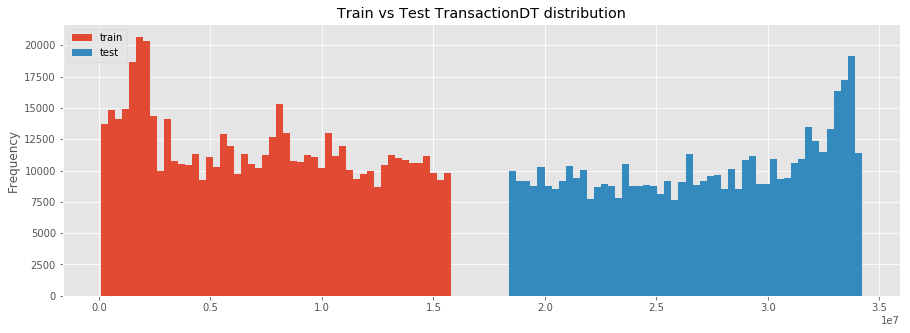

In [7]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

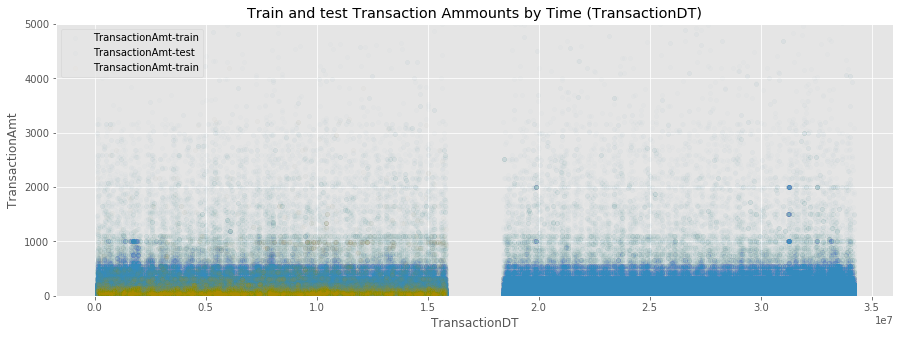

In [8]:
ax = train_transaction.plot(x='TransactionDT',
                       y='TransactionAmt',
                       kind='scatter',
                       alpha=0.01,
                       label='TransactionAmt-train',
                       title='Train and test Transaction Ammounts by Time (TransactionDT)',
                       ylim=(0, 5000),
                       figsize=(15, 5))
test_transaction.plot(x='TransactionDT',
                      y='TransactionAmt',
                      kind='scatter',
                      label='TransactionAmt-test',
                      alpha=0.01,
                      color=color_pal[1],
                       ylim=(0, 5000),
                      ax=ax)
# Plot Fraud as Orange
train_transaction.loc[train_transaction['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()

# Distribution of Target in Training Set
- 3.5% of transacations are fraud

In [9]:
print('  {:.4f}% of Transactions that are fraud in train '.format(train_transaction['isFraud'].mean() * 100))

  3.4990% of Transactions that are fraud in train 


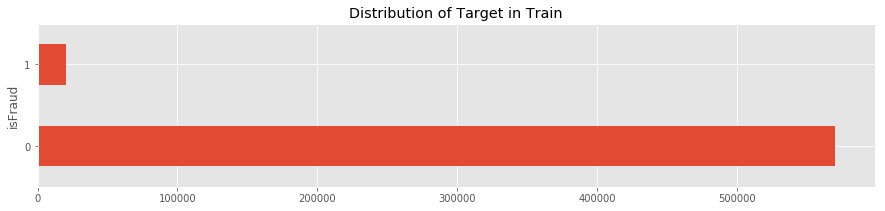

In [10]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

## TransactionAmt
The ammount of transaction. I've taken a log transform in some of these plots to better show the distribution- otherwise the few, very large transactions skew the distribution. Because of the log transfrom, any values between 0 and 1 will appear to be negative.

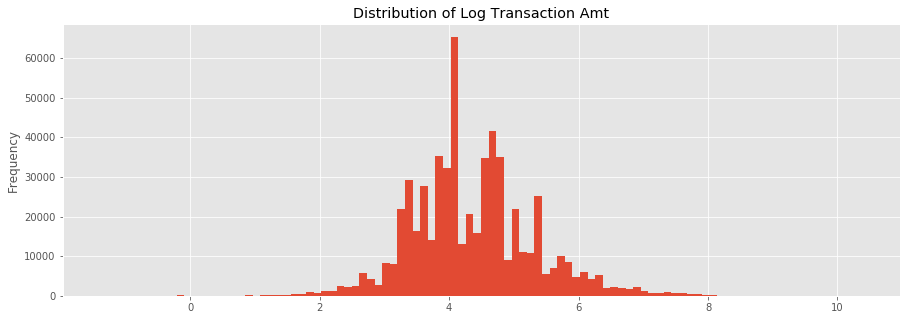

In [11]:
train_transaction['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

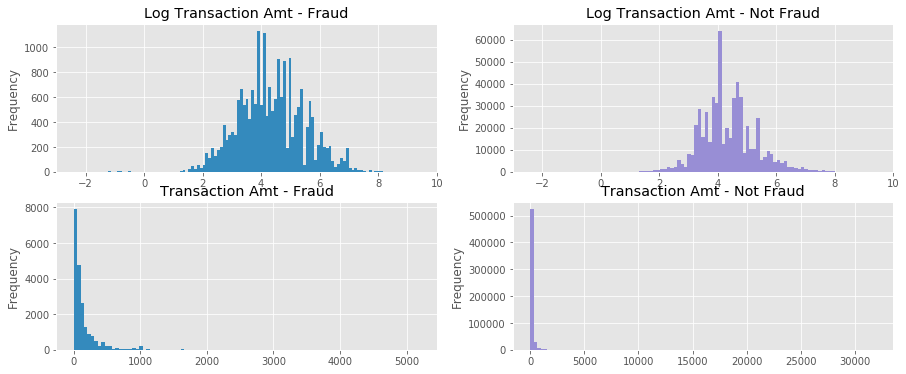

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()

- Fraudulent charges appear to have a higher average transaction ammount 

In [13]:
print('Mean transaction amt for fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


## ProductCD
- For now we don't know exactly what these values represent.
- `W` has the most number of observations, `C` the least.
- ProductCD `C` has the most fraud with >11%
- ProductCD `W` has the least with ~2%

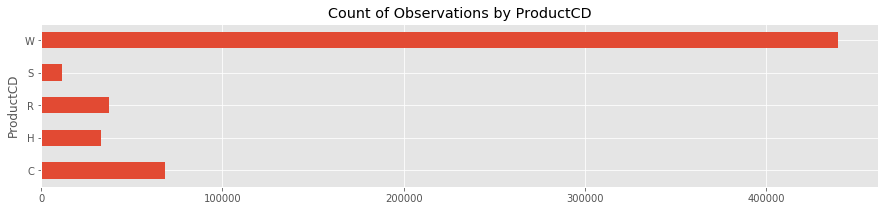

In [14]:
train_transaction.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

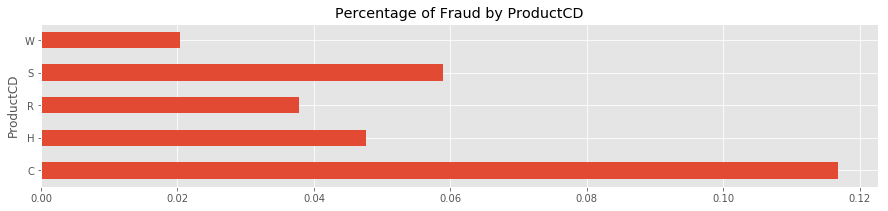

In [15]:
train_transaction.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

# Categorical Features - Transaction
We are told in the data description that the following transaction columns are categorical:
- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

# card1 - card6
- We are told these are all categorical, even though some appear numeric.

In [16]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

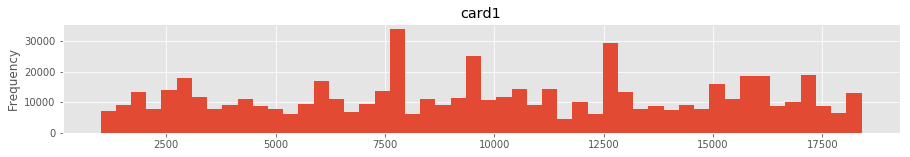

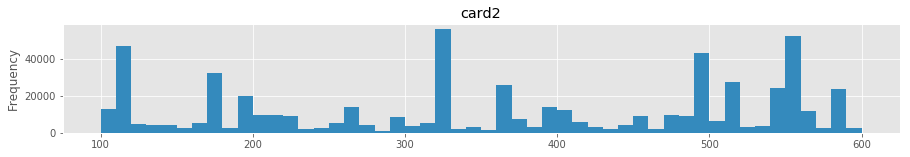

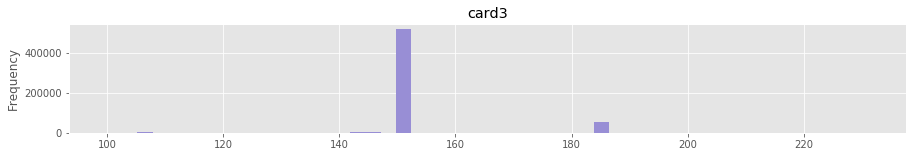

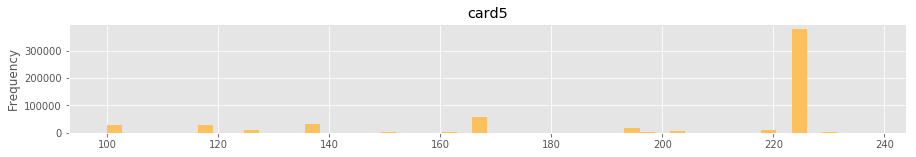

In [17]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

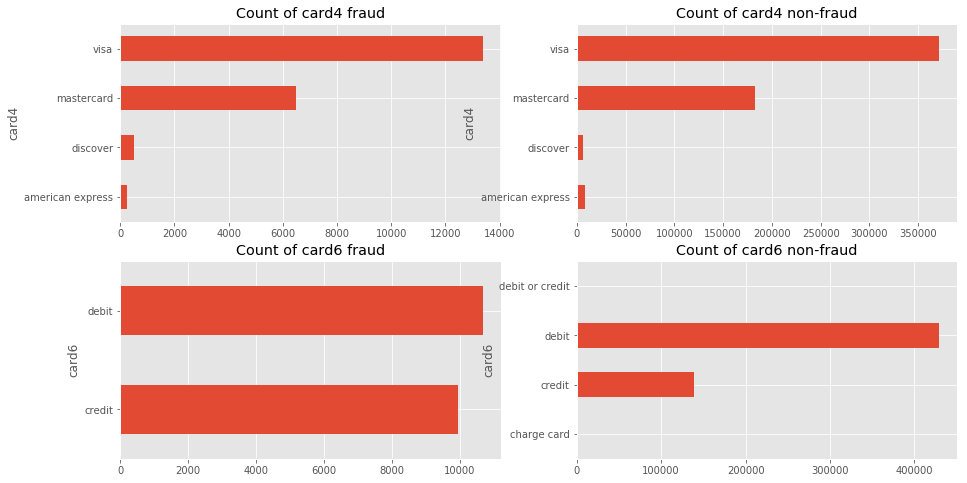

In [18]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

# addr1 & addr2
The data description states that these are categorical even though they look numeric. Could they be the address value?

In [19]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


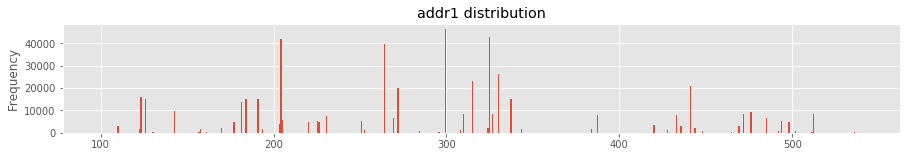

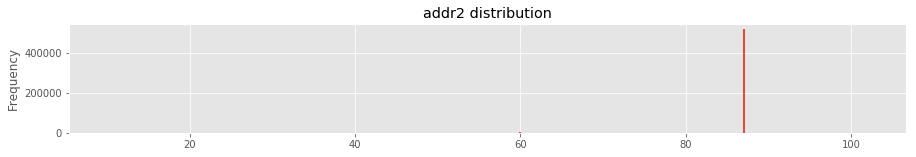

In [20]:
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

# dist1 & dist2
Plotting with logx to better show the distribution. Possibly this could be the distance of the transaction vs. the card owner's home/work address. This is just a guess.

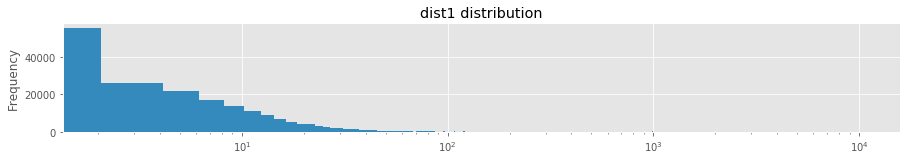

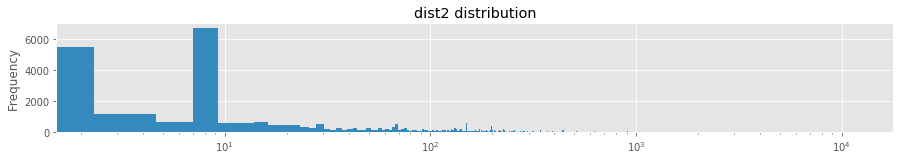

In [21]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

# C1 - C14
Because we are provided many numerical columns, we can create a pairplot to plot feature interactions. I know these plots can be hard to read, but it is helpful for gaining intution about potential feature interactions and if certain features have more variance than others.

In [22]:
c_cols = [c for c in train_transaction if c[0] == 'C']
train_transaction[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

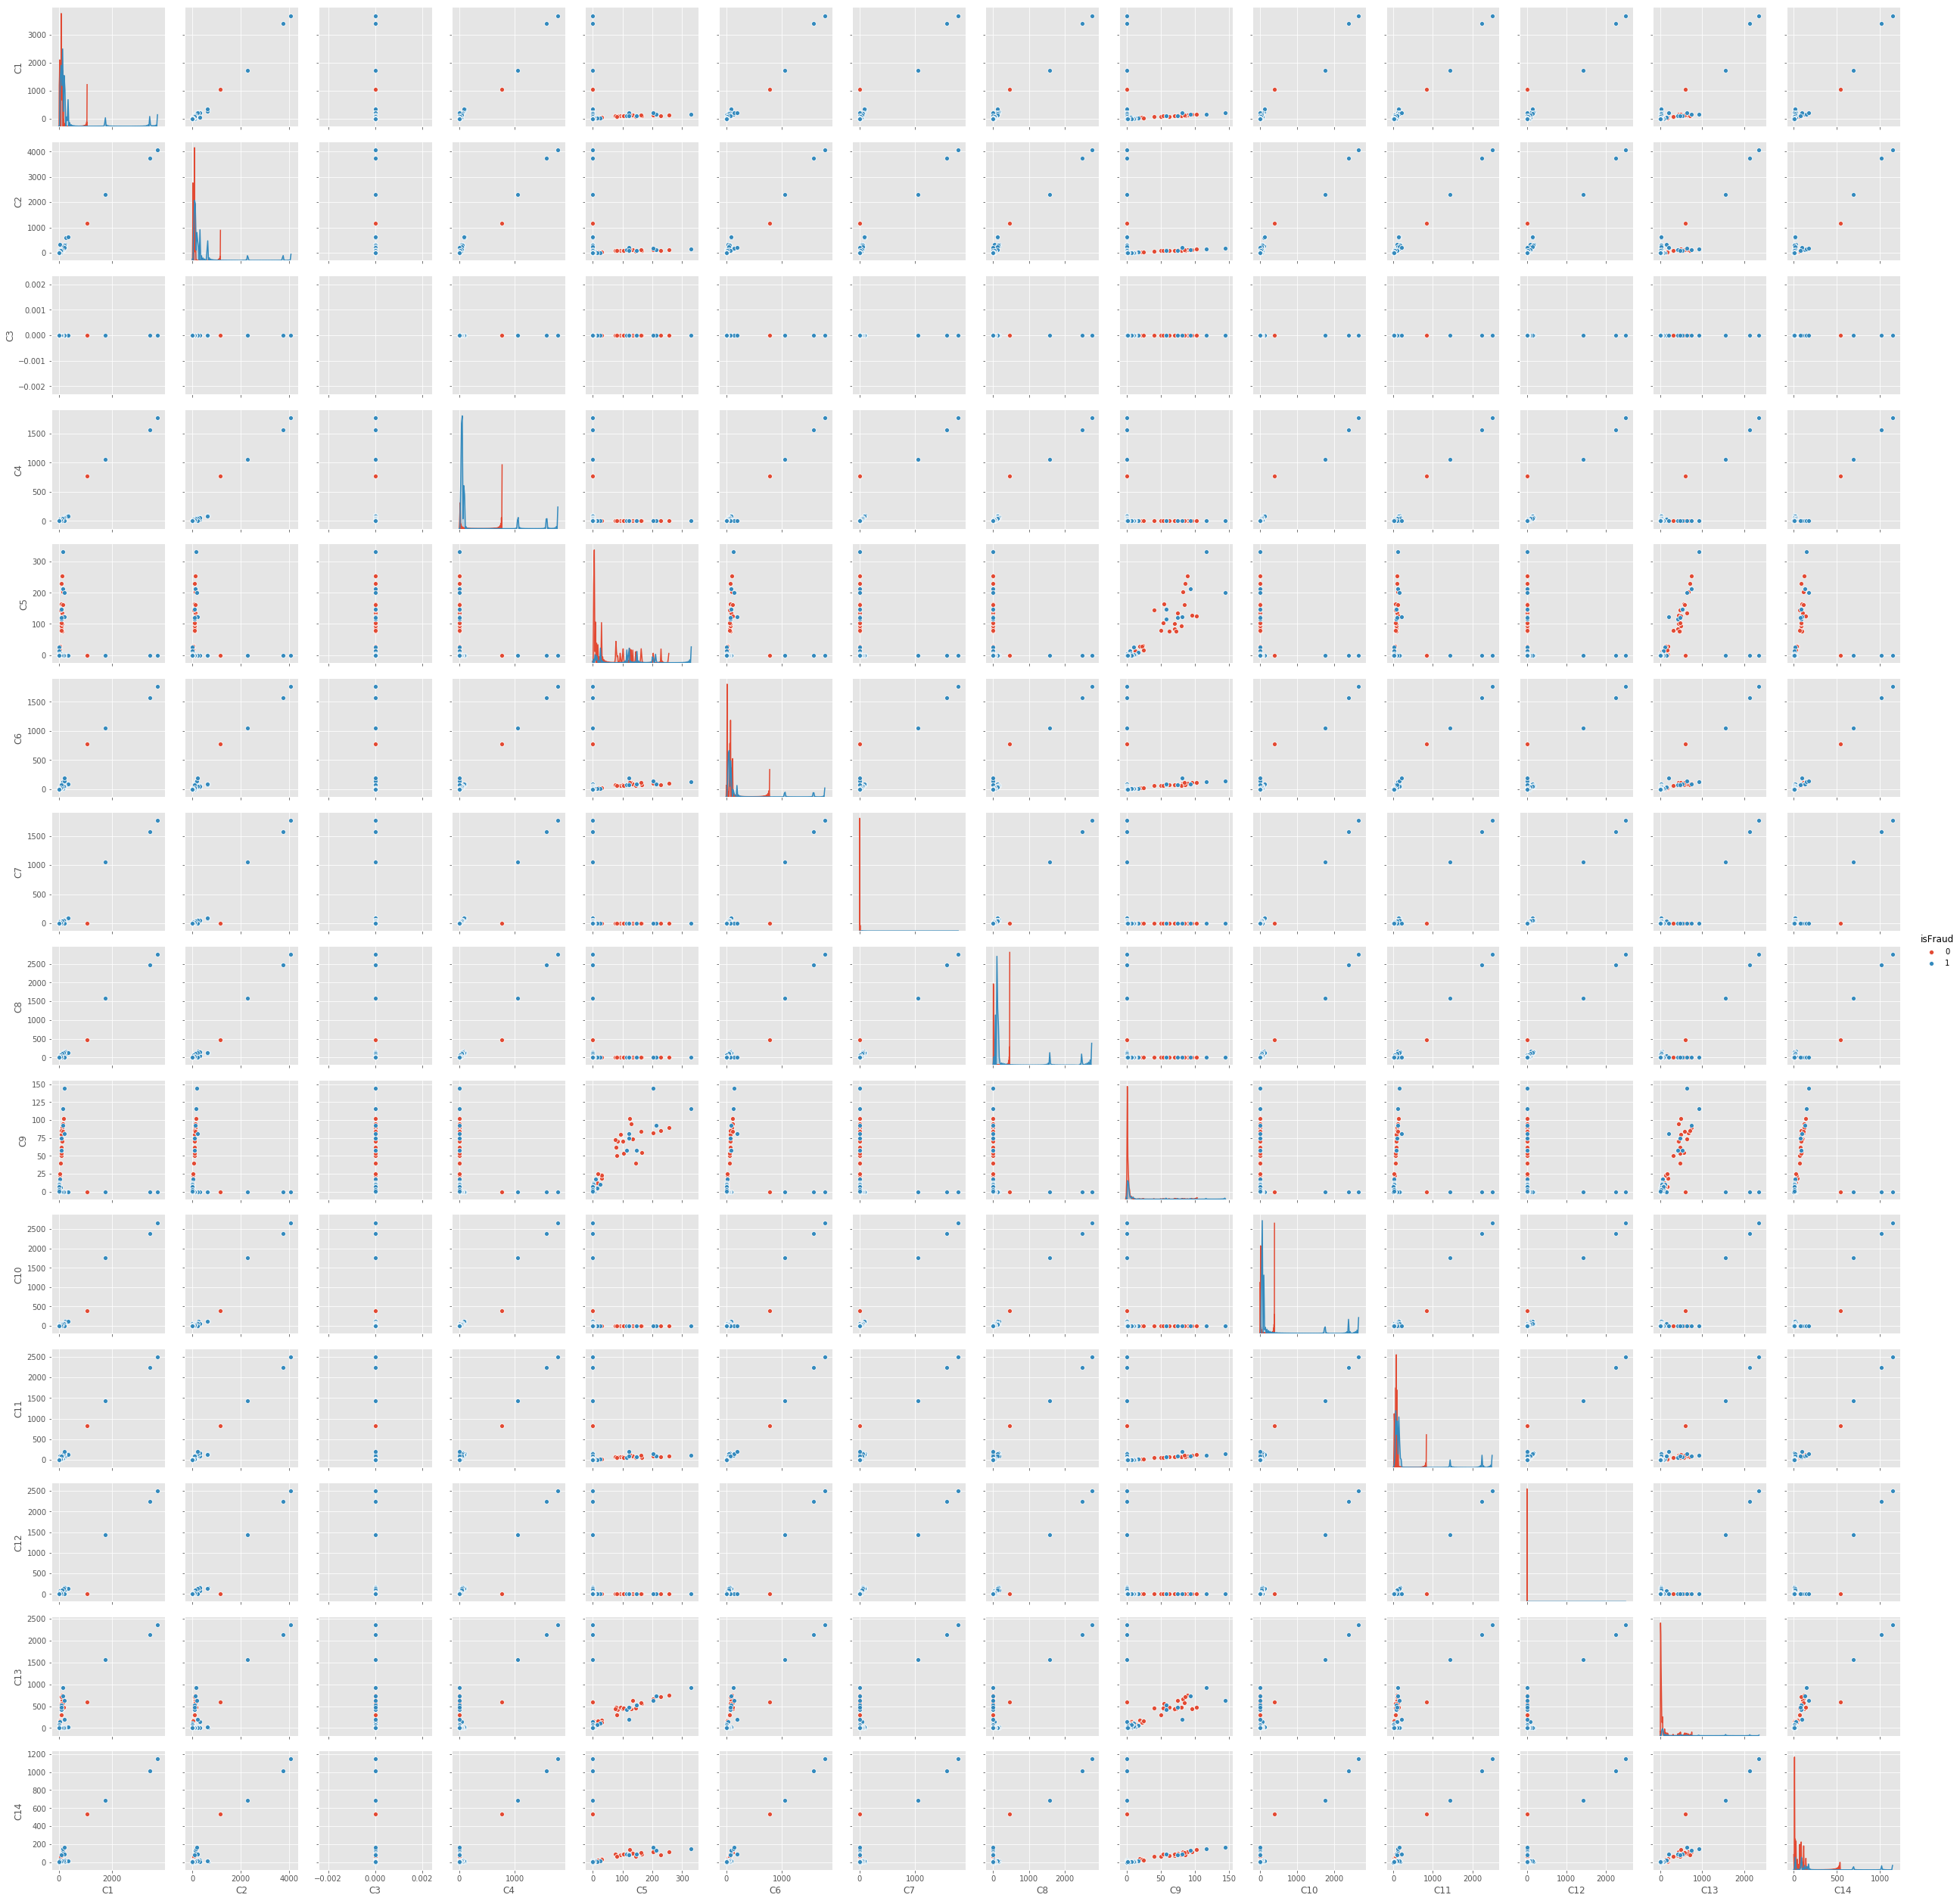

In [23]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

# D1-D9
Similarly for features D1-D9. In these plots we can see some linear and non-linear interactions between features. We may want to create additional features using these interactions if we think it would help our model better find relationship between fraud and non-fraud observations.

In [24]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN

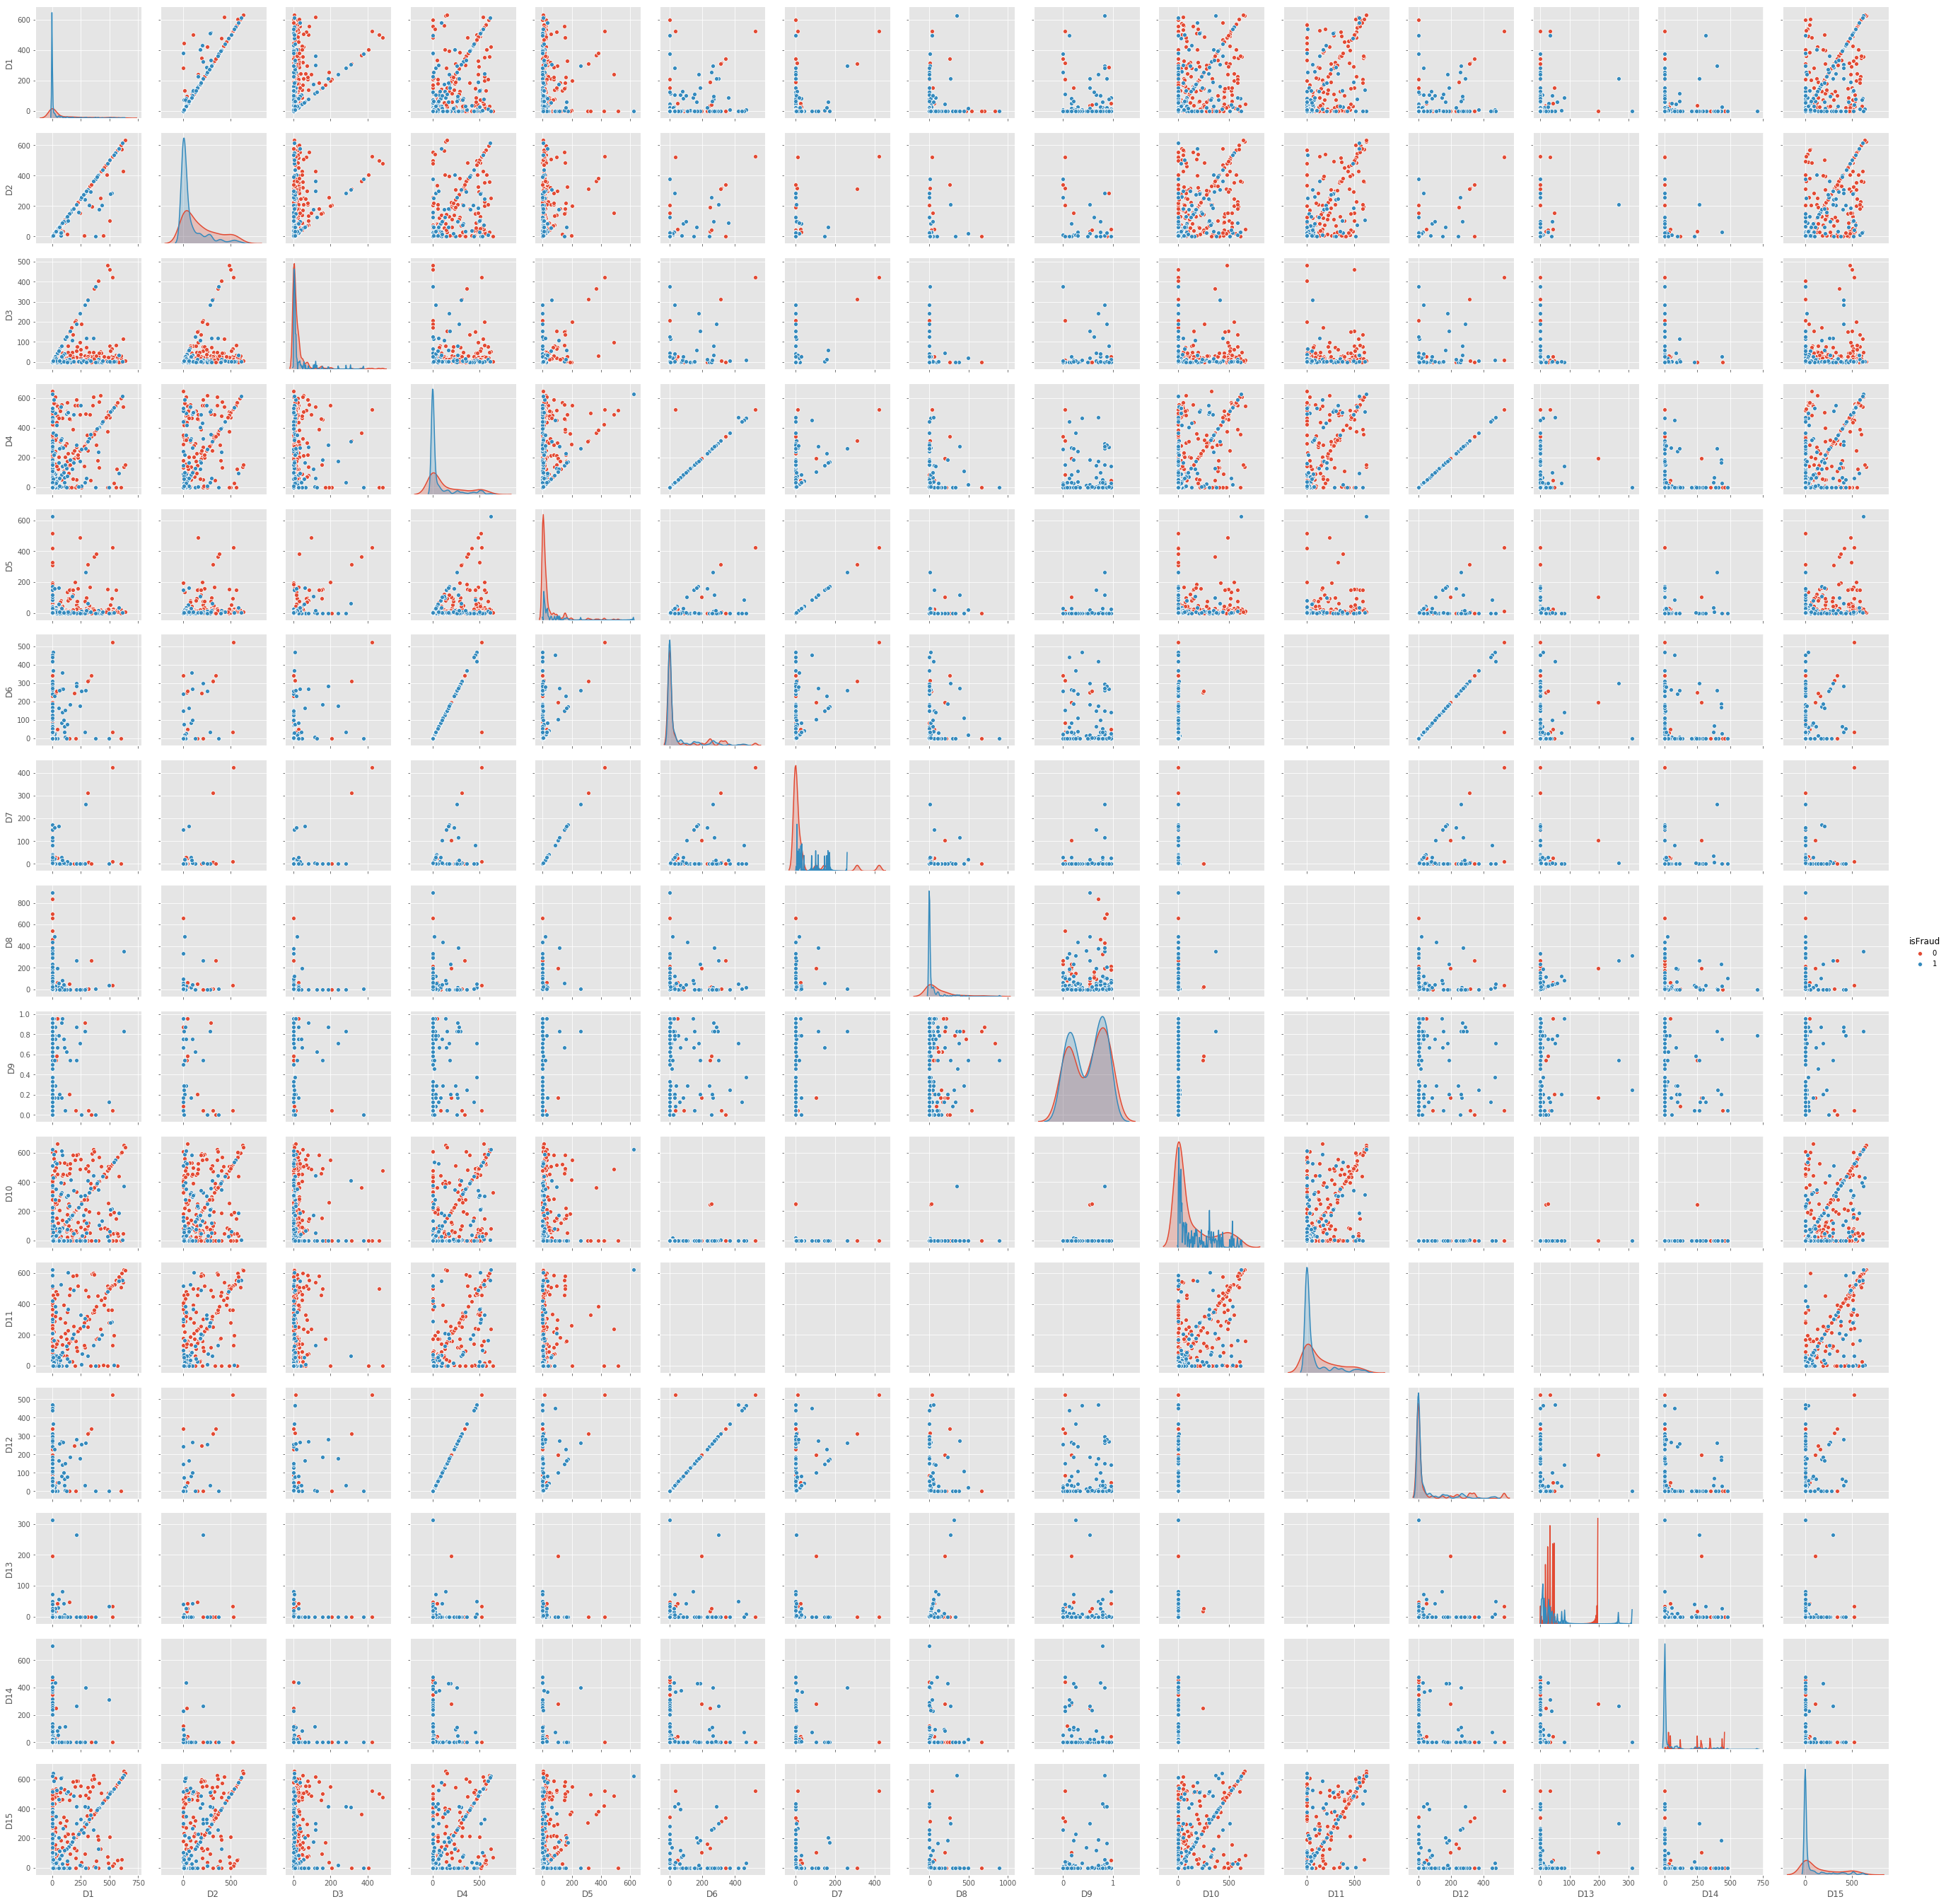

In [25]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

# M1-M9
- Values are `T` `F` or `NaN`
- Column `M4` appears to be different with values like `M2` and `M0`

In [26]:
m_cols = [c for c in train_transaction if c[0] == 'M']
train_transaction[m_cols].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

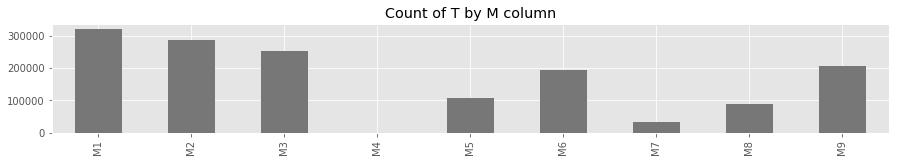

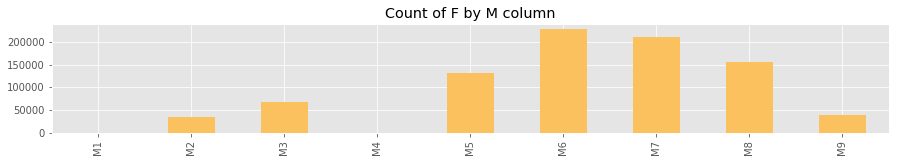

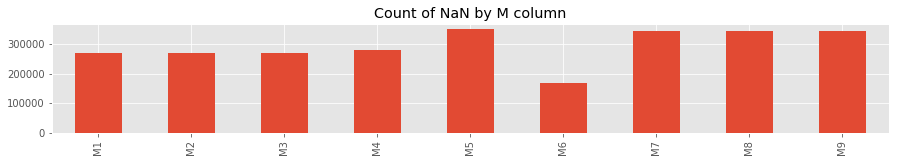

In [27]:
(train_transaction[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Count of T by M column',
                                              figsize=(15, 2),
                                              color=color_pal[3])
plt.show()
(train_transaction[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Count of F by M column',
                                              figsize=(15, 2),
                                              color=color_pal[4])
plt.show()
(train_transaction[m_cols].isna()).sum().plot(kind='bar',
                                              title='Count of NaN by M column',
                                              figsize=(15, 2),
                                              color=color_pal[0])
plt.show()

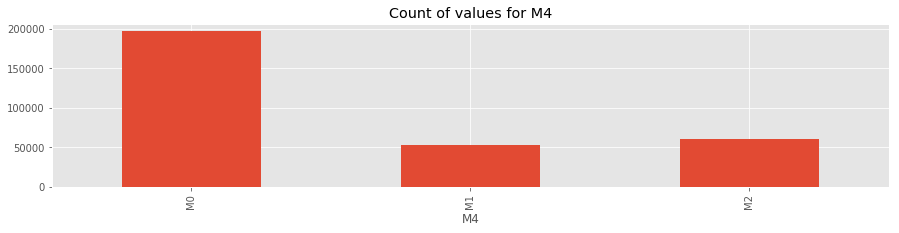

In [28]:
# Looking at M4 column since it is different than the others
train_transaction.groupby('M4')['TransactionID'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M4',
          figsize=(15, 3))
plt.show()

# V1 - V339
Lots of 1s 0s and Nans, some larger values

In [29]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

In [30]:
train_transaction[v_cols].describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311253.000000  311253.000000  ...  82351.000000   82351.000000   
mean        1.041529       0.463915  ...      0.775874     721.741883   
std         0.226339       0.521522  ...      4.727971    6217.223583   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

In [31]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

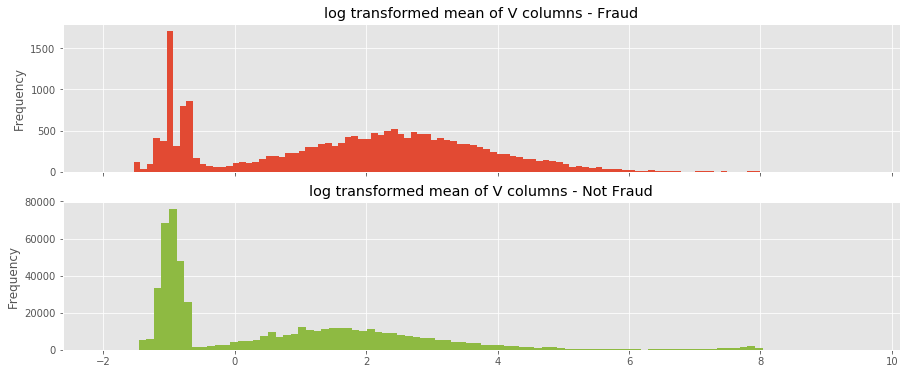

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

# Identity Data
Next we will explore the identity data. These are provided for some, but not all `TransactionID`s. It contains information about the identity of the customer.
- Categorical Features
- `DeviceType`
- `DeviceInfo`
- `id_12` - `id_38`

In [33]:
# Add the `isFraud` column for analysis
train_identity_ = train_identity.merge(train_transaction[['TransactionID',
                                                         'TransactionDT',
                                                         'isFraud']],
                                      on=['TransactionID'])

test_identity_ = test_identity.merge(test_transaction[['TransactionID',
                                                      'TransactionDT']],
                                    on=['TransactionID'])

## DeviceType

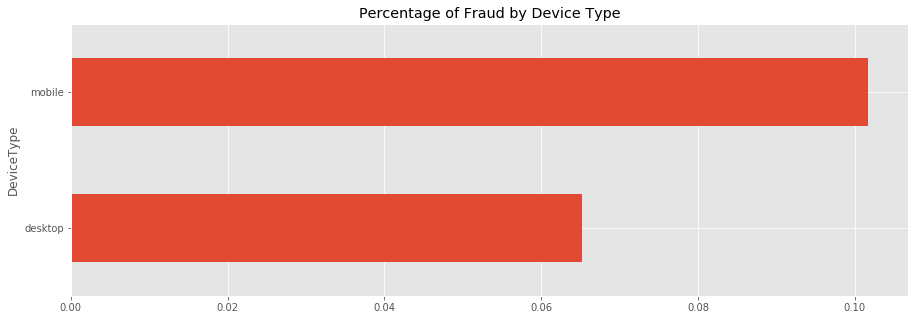

In [34]:
train_identity_.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

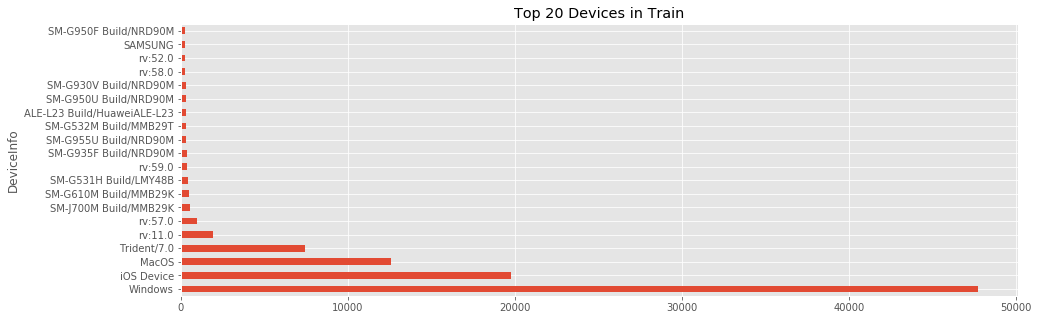

In [35]:
train_identity_.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

## Identity info as a function of time

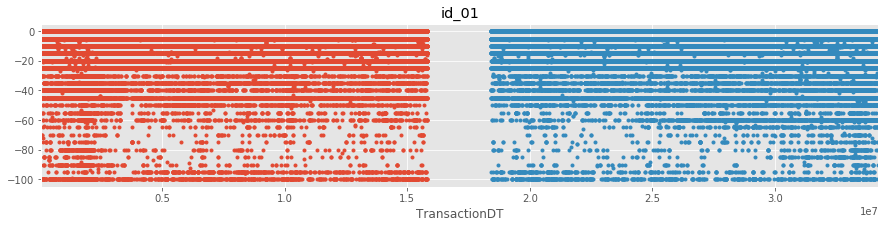

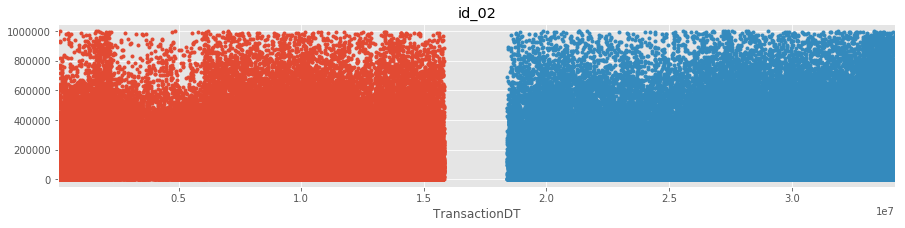

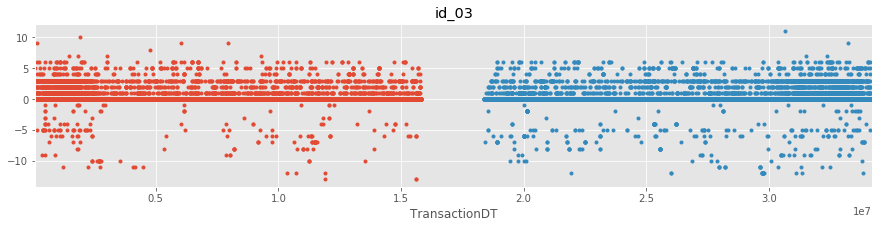

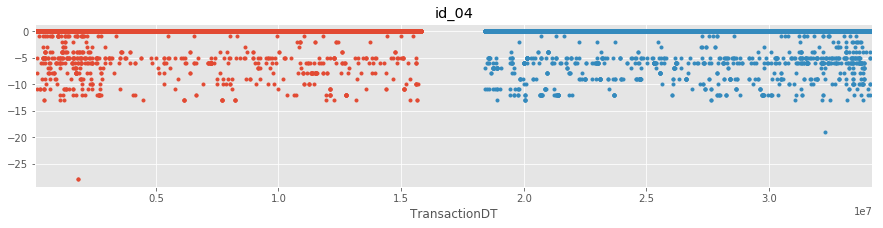

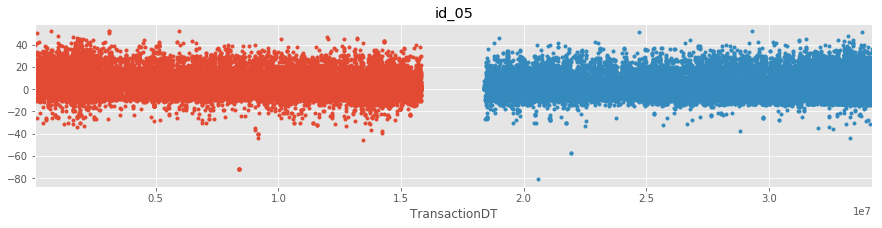

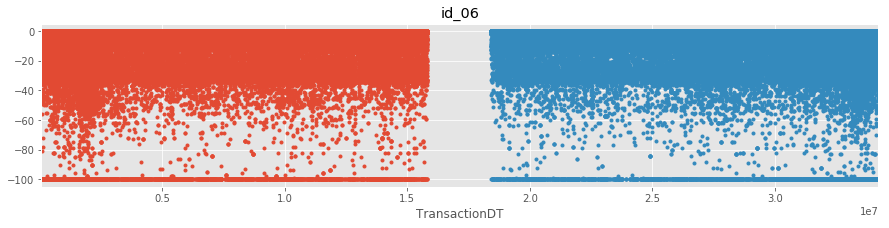

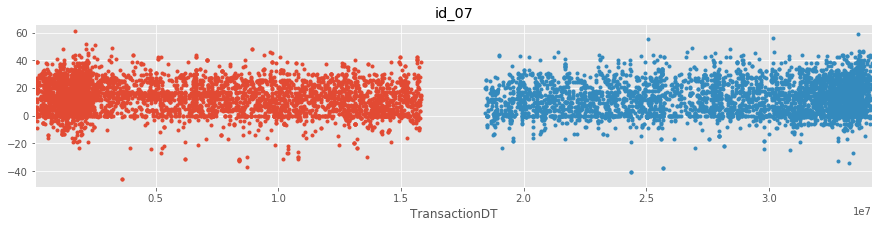

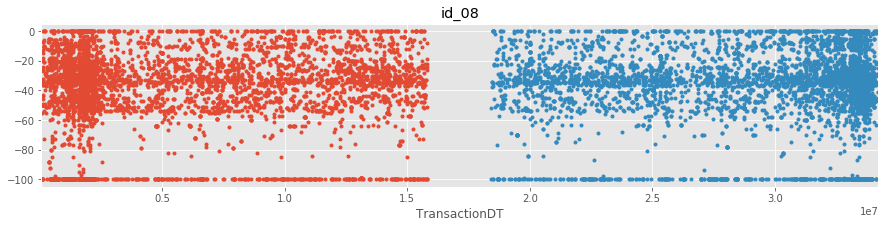

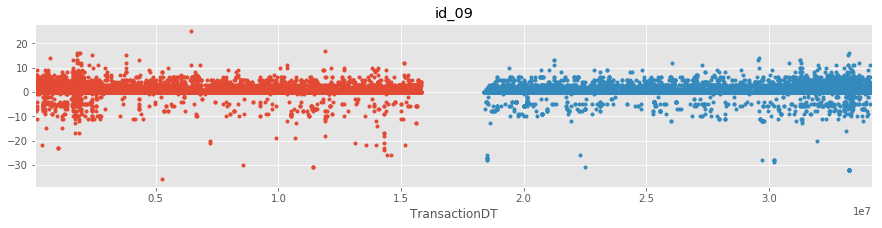

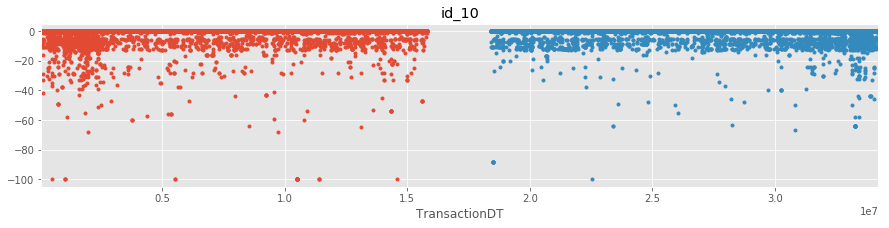

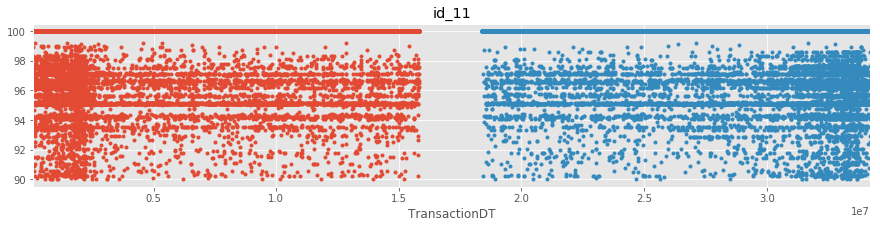

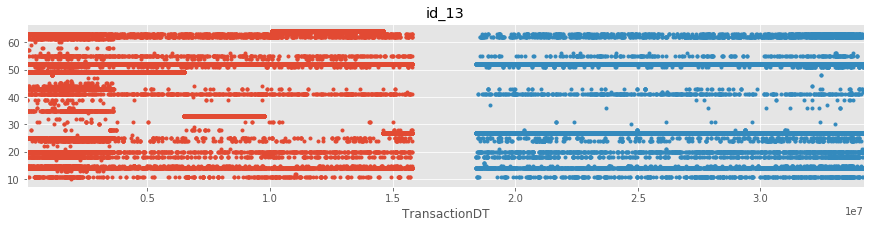

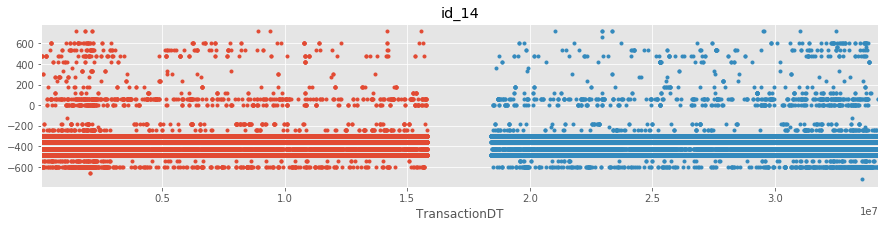

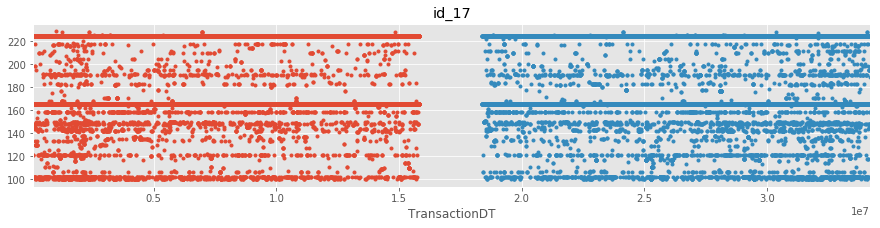

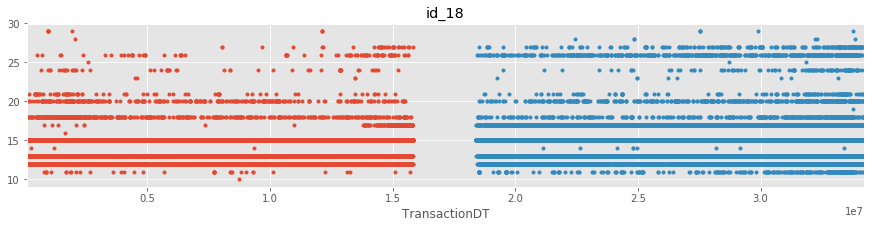

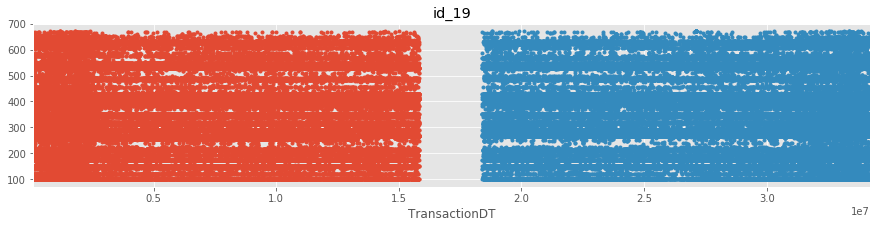

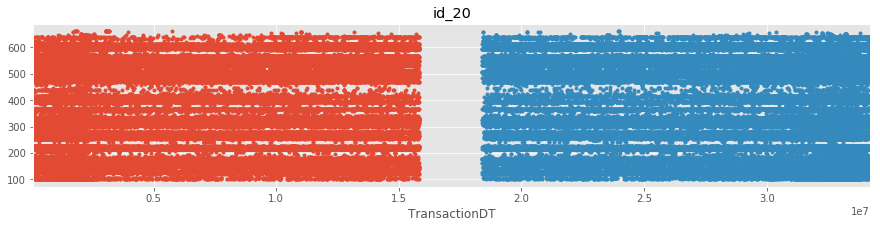

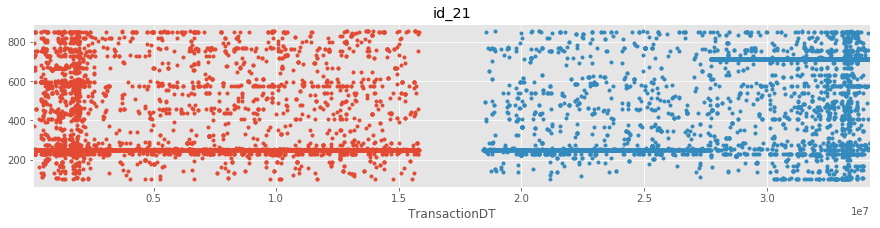

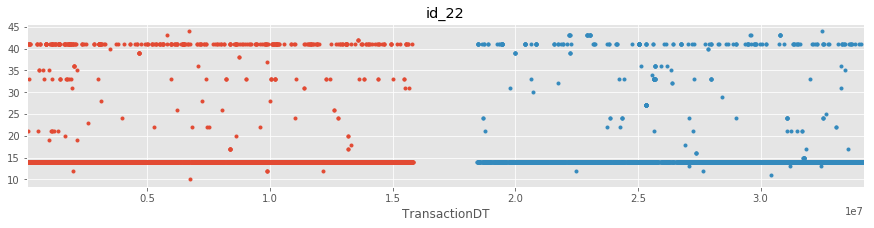

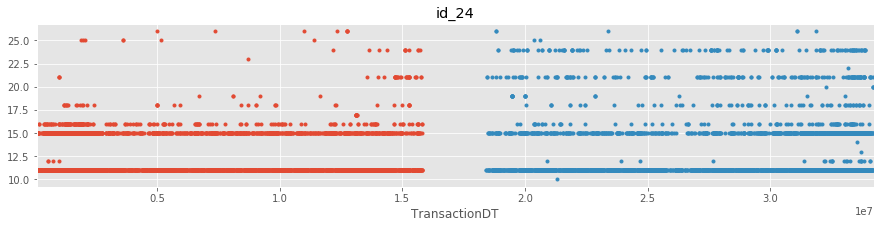

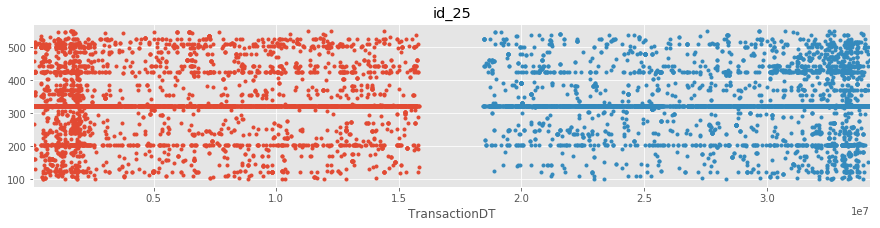

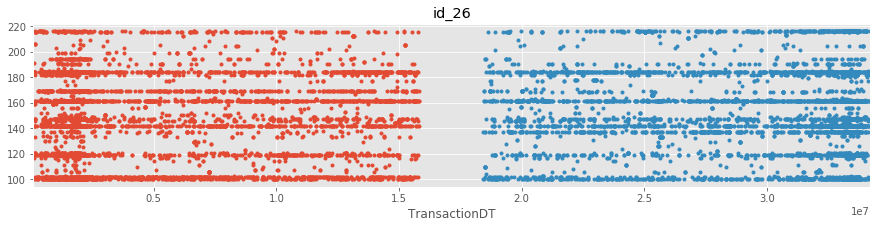

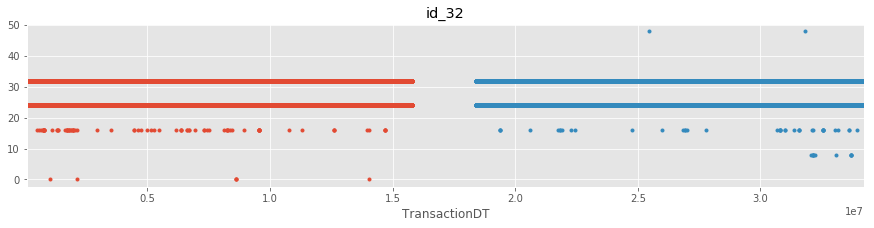

In [36]:
id_cols = [c for c in train_identity.columns if 'id' in c]
for i in id_cols:
    try:
        train_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        test_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass

## Compare Numeric Features in Train and Test
Similar to above but for the transaction data, specific examples that look interesting.

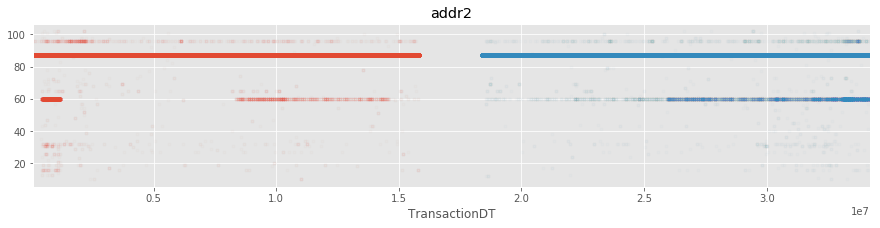

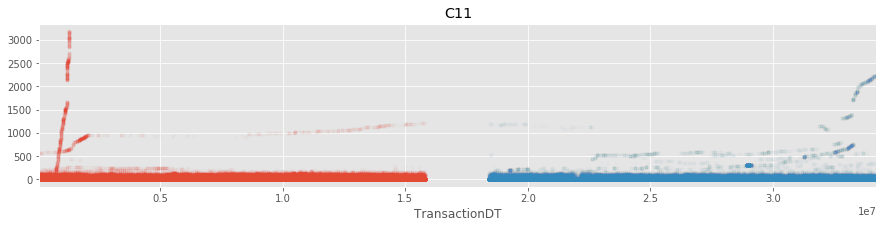

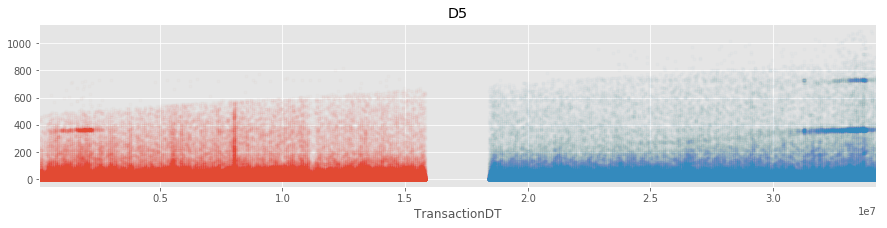

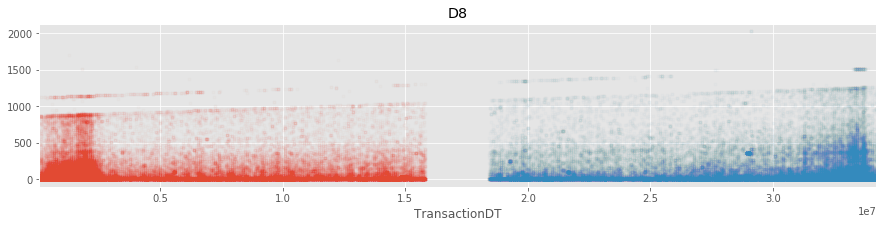

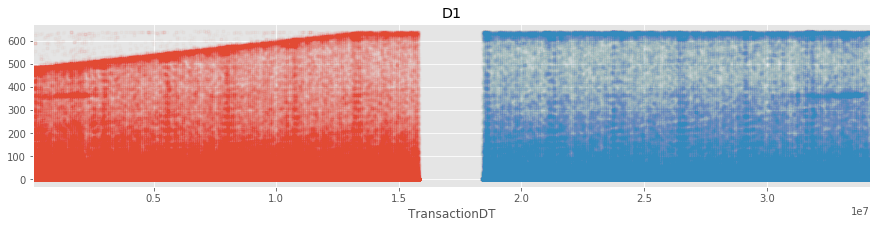

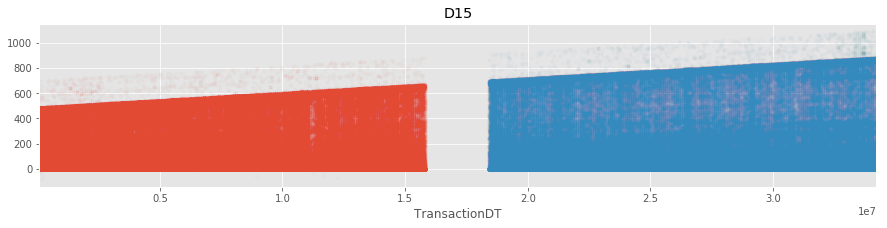

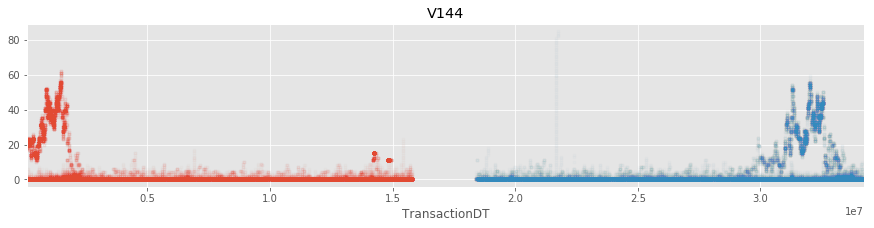

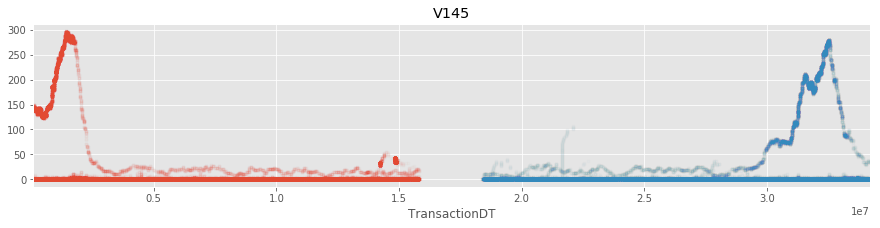

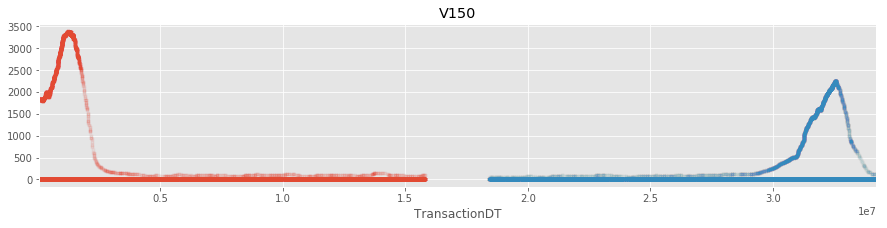

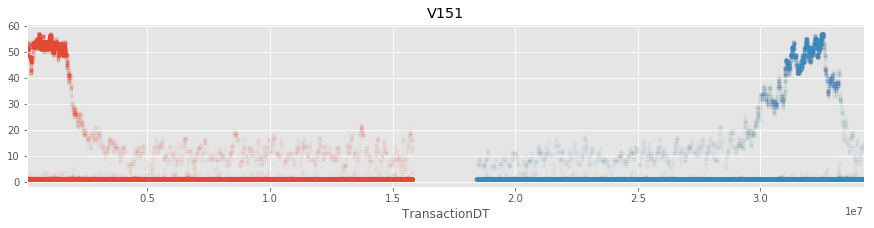

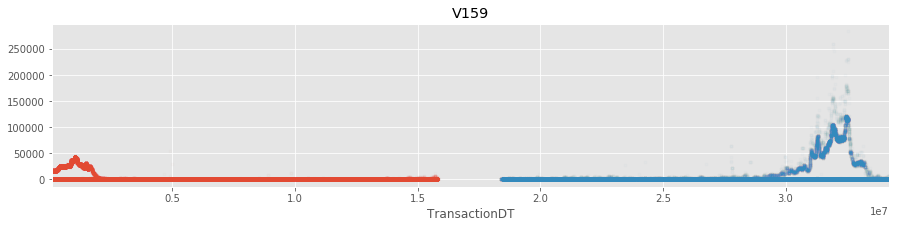

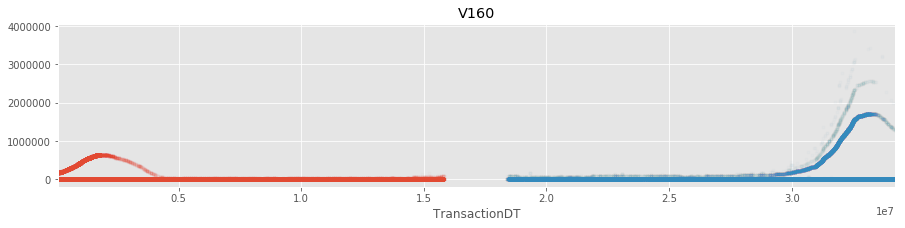

In [37]:
for c in ['addr2','C11','D5','D8','D1','D15','V144','V145','V150','V151','V159','V160']:
    try:
        train_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass

MemoryError: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn import ensemble
classifiers = [
    #Ensemble Methods
#     ensemble.AdaBoostClassifier(),
#     ensemble.BaggingClassifier(),
#     ensemble.ExtraTreesClassifier(),
#     ensemble.GradientBoostingClassifier(),
#     ensemble.RandomForestClassifier(n_estimators = 100),
    #ensemble.VotingClassifier(),
    
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")